In [1]:
from models.classification_model import ClassifierModel # class with classifiers
from models.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
from cycler import cycler
# ide_plot() #plot for github dark theme

In [2]:
plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["grid.color"] = 'black'
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.labelcolor"] = 'black'
plt.rcParams["axes.titlecolor"] = 'black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

In [3]:
import joblib

reduce_model = joblib.load("models/best/reduce_model.pkl")

c_model = joblib.load("models/best/c_model.pkl")

res = joblib.load("models/best/best_params.pkl")

scaler = joblib.load("models/best/scaler.pkl")


In [4]:
test_mofs = pd.read_csv("preprocessing/datasets/test_cifs.csv", index_col=0)
test_mofs = pd.DataFrame(reduce_model.transform(test_mofs.values), index=test_mofs.index,)

In [5]:
# load MOFs with T and solvent PT
t_solvent = np.load("preprocessing/datasets/t_solvent.npy")

In [6]:
# Load main dataset
dataset = pd.read_csv("preprocessing/datasets/main_dataset.csv", index_col=0)
target = pd.read_csv("preprocessing/datasets/main_target.csv", index_col=0)

In [7]:
# reduce main dataset
main_reduced = pd.DataFrame(reduce_model.transform(dataset), index=dataset.index)
# reduce QMOF
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

In [8]:
len(qmof_reduced), len(main_reduced), len(t_solvent), len(test_mofs)

(7463, 83, 3, 6)

In [9]:
# concatenate QMOF, main, T-Solvent 
cat_ = np.array([*qmof_reduced, *main_reduced.values, *t_solvent, *test_mofs.values])


In [10]:
len(cat_)

7555

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(scaler.transform(cat_))

In [20]:
# X_t -- TSNE of QMOF and main, t_s of T-Solvent 
X_t, tests = X_t[:-6,:], X_t[-6:, :]
X_t, t_s = X_t[:-3,:], X_t[-3:, :]

In [25]:
xt_q = X_t[:qmof_reduced.shape[0]] # QMOF

xt_m = X_t[qmof_reduced.shape[0]:] # main
pr_m = target.values.ravel()

In [31]:
pr_q = {name: c_model.models[name].predict_proba(scaler.transform(qmof_reduced))[:,1] for name in c_model.models} # predicted probability 

In [28]:
len(xt_q), len(xt_m), len(t_s), len(tests)

(7463, 83, 3, 6)

In [34]:
len(pr_q["kNN"]), len(pr_m)

(7463, 83)

In [29]:
len(xt_q)+ len(xt_m)+ len(t_s)+ len(tests)

7555

# Figures

In [35]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

In [36]:
summer = mpl.colormaps['summer'].resampled(250)
newcolors = summer(np.linspace(0, 1, 250))
gray = np.array([110/250, 112/250, 110/250, 1])
green = np.array([0/250,128/250,0,1])
yellow = np.array([1,1,0,1])
gap = 0.2
top, bottom = int(len(newcolors) * 0.8), int(len(newcolors) * 0.2)
newcolors[top:, :] = yellow
newcolors[bottom:top, :] = gray
newcolors[:bottom, :] = green
newcmp = ListedColormap(newcolors)

In [37]:
def plot_high_confident(ax, name):
    gap = 0.2
    ax.set_title(name, size=20)
    guest_mol_ind = np.where(pr_q[name] >= 1 - gap)[0]
    tp_ind = np.where(pr_q[name] <= gap)[0]
    no_transition = np.where([p < 1- gap and p > gap for p in pr_q[name]])[0]
    ax.scatter(xt_q[no_transition, 0], xt_q[no_transition, 1], s=80, alpha=0.5, linewidths=0.3, edgecolors='black', c="gray") # label="no prediction"
    ax.scatter(xt_q[guest_mol_ind, 0], xt_q[guest_mol_ind, 1], s=80, alpha=1, linewidths=0.3, edgecolors='black', c='yellow', label=f"guest mol. ({len(guest_mol_ind)})") # label=f"predicted guest mol. transform: {len(guest_mol_ind)}"
    ax.scatter(xt_q[tp_ind, 0], xt_q[tp_ind, 1], s=60, alpha=1, linewidths=0.3, edgecolors='black', c='green',  label=f"T-P ({len(tp_ind)})") # label=f"predicted T-P transform: {len(tp_ind)}"
    ax.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', edgecolors='r', color='green', s=100) # , label='t-p (main)'
    ax.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', edgecolors='r', color='yellow', s=100) # , label='guest molecules (main)'
    #ax.legend(loc=2, fontsize="large")
    ax.axis("equal")
    ax.tick_params(axis='both',label1On=False, size=5)
    ax.set_xlabel("TSNE1", size=20)
    ax.set_ylabel("TSNE2", size=20)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    print(f"{name}: number of predicted MOFs with ability to s. tr. under guest mol.: {len(guest_mol_ind)} ")
    print(f"{name}: number of predicted MOFs with ability to s. tr. T-P : {len(tp_ind)} ")



In [38]:
c_model.models["kNN"].predict_proba(scaler.transform(t_solvent))[:,1]

array([0.21909327, 0.84901067, 0.22140753])

In [25]:
# train, test = pd.read_csv("preprocessing/datasets/qmof_train.csv", index_col=0), pd.read_csv("preprocessing/datasets/qmof_train.csv", index_col=0)
# d = pd.concat([train, test], axis=0)

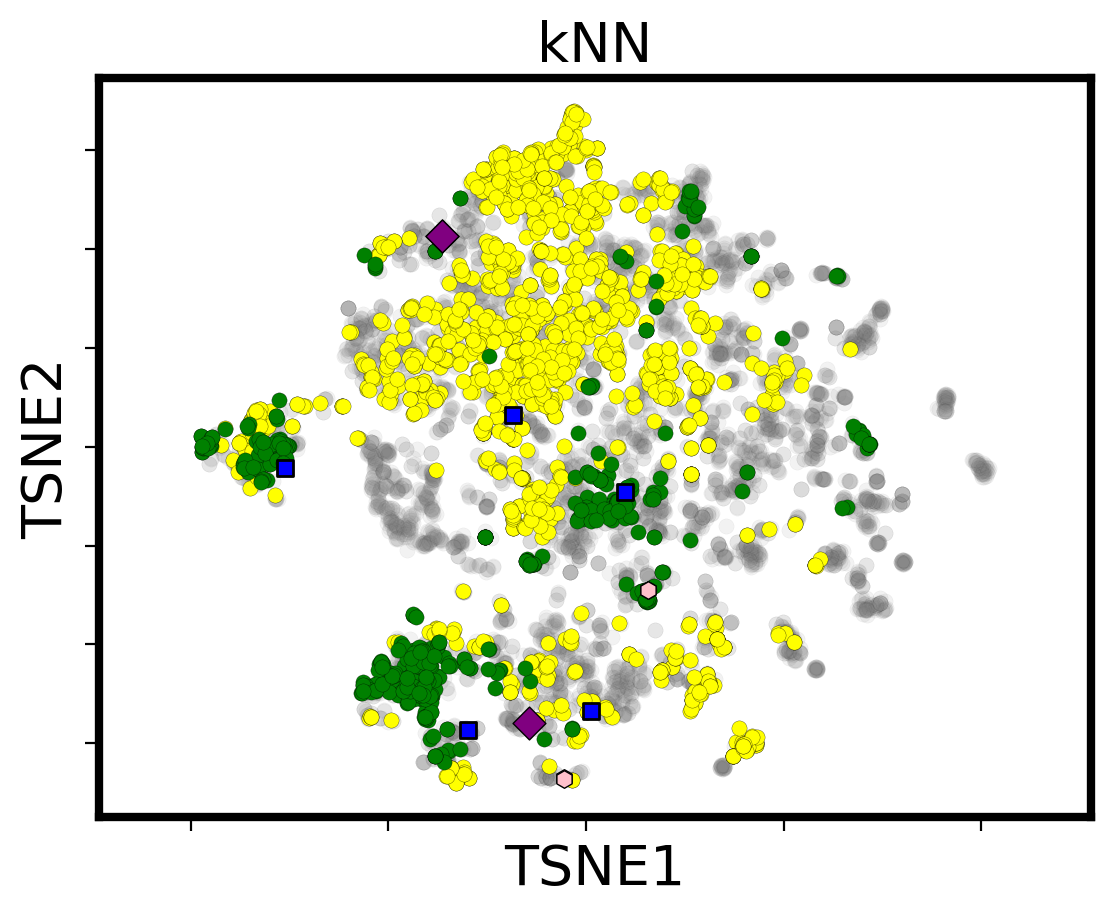

In [39]:
# plot support 

fig, ax = plt.subplots(1, 1, dpi=200)
gap = 0.2
ax.set_title("kNN", size=20)
guest_mol_ind = np.where(pr_q["kNN"] >= 1 - gap)[0]
tp_ind = np.where(pr_q["kNN"] <= gap)[0]
no_transition = np.where([p < 1- gap and p > gap for p in pr_q["kNN"]])[0]
ax.scatter(xt_q[no_transition, 0], xt_q[no_transition, 1], s=30, alpha=0.1, linewidths=0.1, edgecolors='black', c="gray") # label="no prediction"
ax.scatter(xt_q[guest_mol_ind, 0], xt_q[guest_mol_ind, 1], s=30, alpha=1, linewidths=0.1, edgecolors='black', c='yellow', label=f"guest mol. ({len(guest_mol_ind)})") 
ax.scatter(xt_q[tp_ind, 0], xt_q[tp_ind, 1], s=30, alpha=1, linewidths=0.1, edgecolors='black', c='green',  label=f"T-P ({len(tp_ind)})") # label=f"predicted T-P transform: {len(tp_ind)}"
ax.axis("equal")
ax.tick_params(axis='both',label1On=False, size=5)
ax.set_xlabel("TSNE1", size=20)
ax.set_ylabel("TSNE2", size=20)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

described = [
            1833, # 3
            # 266,  # 5
            572,  # 8
            213,  # 10
            2610, # 18
            182   # 21
            ]
d_names = ["VEXPAS_FSR",
           "COWKIJ_FSR",
           "TABQAR_FSR",
           "HUTZAX_FSR",
           "RINWAO_FSR"]
ax.scatter(xt_q[described, 0], xt_q[described, 1], s=30, marker="s", alpha=1, linewidths=1, edgecolor='black', c='blue')
# for i, ind in enumerate(described):
#     ax.text(xt_q[ind, 0]-20, xt_q[ind, 1]+5, d_names[i])
ax.scatter(t_s[:, 0], t_s[:, 1], s=70, marker="D", alpha=1, edgecolors='black', linewidths=0.5, c='purple')

ax.scatter(tests[[0, 1, 4, 5], 0], tests[[0, 1, 4, 5], 1], s=40, marker="h", alpha=1, edgecolors='black', linewidths=0.5, c='pink')
# for i, name in enumerate(test_mofs.index):
#     ax.text(tests[i, 0], tests[i, 1] + np.random.random()*20, name)

# plt.savefig("tsne_with_Described_T_Sol_tests.pdf")

# for point, name in zip(t_s, ["topart4", "from11974527", "frompart2"]):
#     ax.text(point[0], point[1] + np.random.rand()*20, name)



In [40]:
def plot_high_confident(ax, name):
    gap = 0.2
    ax.set_title(name, size=6)
    guest_mol_ind = np.where(pr_q[name] >= 1 - gap)[0]
    tp_ind = np.where(pr_q[name] <= gap)[0]
    no_transition = np.where([p < 1- gap and p > gap for p in pr_q[name]])[0]
    ax.scatter(xt_q[no_transition, 0], xt_q[no_transition, 1], s=10, alpha=0.5, linewidths=0.1, edgecolors='black', c="#a1a1a1") # label="no prediction"
    ax.scatter(xt_q[guest_mol_ind, 0], xt_q[guest_mol_ind, 1], s=10, alpha=1, linewidths=0.1, edgecolors='black', c='yellow', label=f"guest mol. ({len(guest_mol_ind)})") # label=f"predicted guest mol. transform: {len(guest_mol_ind)}"
    ax.scatter(xt_q[tp_ind, 0], xt_q[tp_ind, 1], s=10, alpha=1, linewidths=0.1, edgecolors='black', c='green',  label=f"T-P ({len(tp_ind)})") # label=f"predicted T-P transform: {len(tp_ind)}"
    ax.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', linewidths=0.7, edgecolors='r', color='green', s=15) # , label='t-p (main)'
    ax.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', linewidths=0.7, edgecolors='r', color='yellow', s=15) # , label='guest molecules (main)'
    #ax.legend(loc=2, fontsize="large")
    ax.axis("equal")
    ax.tick_params(axis='both',label1On=False, size=2)
    ax.set_xlabel("TSNE1", size=6)
    ax.set_ylabel("TSNE2", size=6)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    print(f"{name}: number of predicted MOFs with ability to s. tr. under guest mol.: {len(guest_mol_ind)} ")
    print(f"{name}: number of predicted MOFs with ability to s. tr. T-P : {len(tp_ind)} ")


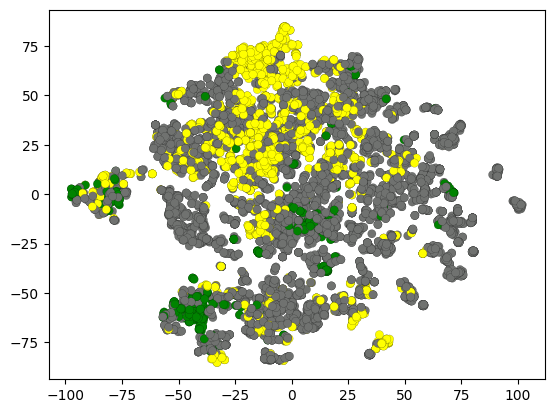

In [41]:
map = plt.scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, edgecolors='black', c=pr_q["kNN"], cmap=newcmp)


CatBoost: number of predicted MOFs with ability to s. tr. under guest mol.: 0 
CatBoost: number of predicted MOFs with ability to s. tr. T-P : 0 
kNN: number of predicted MOFs with ability to s. tr. under guest mol.: 1646 
kNN: number of predicted MOFs with ability to s. tr. T-P : 539 
AdaBoost: number of predicted MOFs with ability to s. tr. under guest mol.: 3906 
AdaBoost: number of predicted MOFs with ability to s. tr. T-P : 2159 
RF: number of predicted MOFs with ability to s. tr. under guest mol.: 875 
RF: number of predicted MOFs with ability to s. tr. T-P : 76 


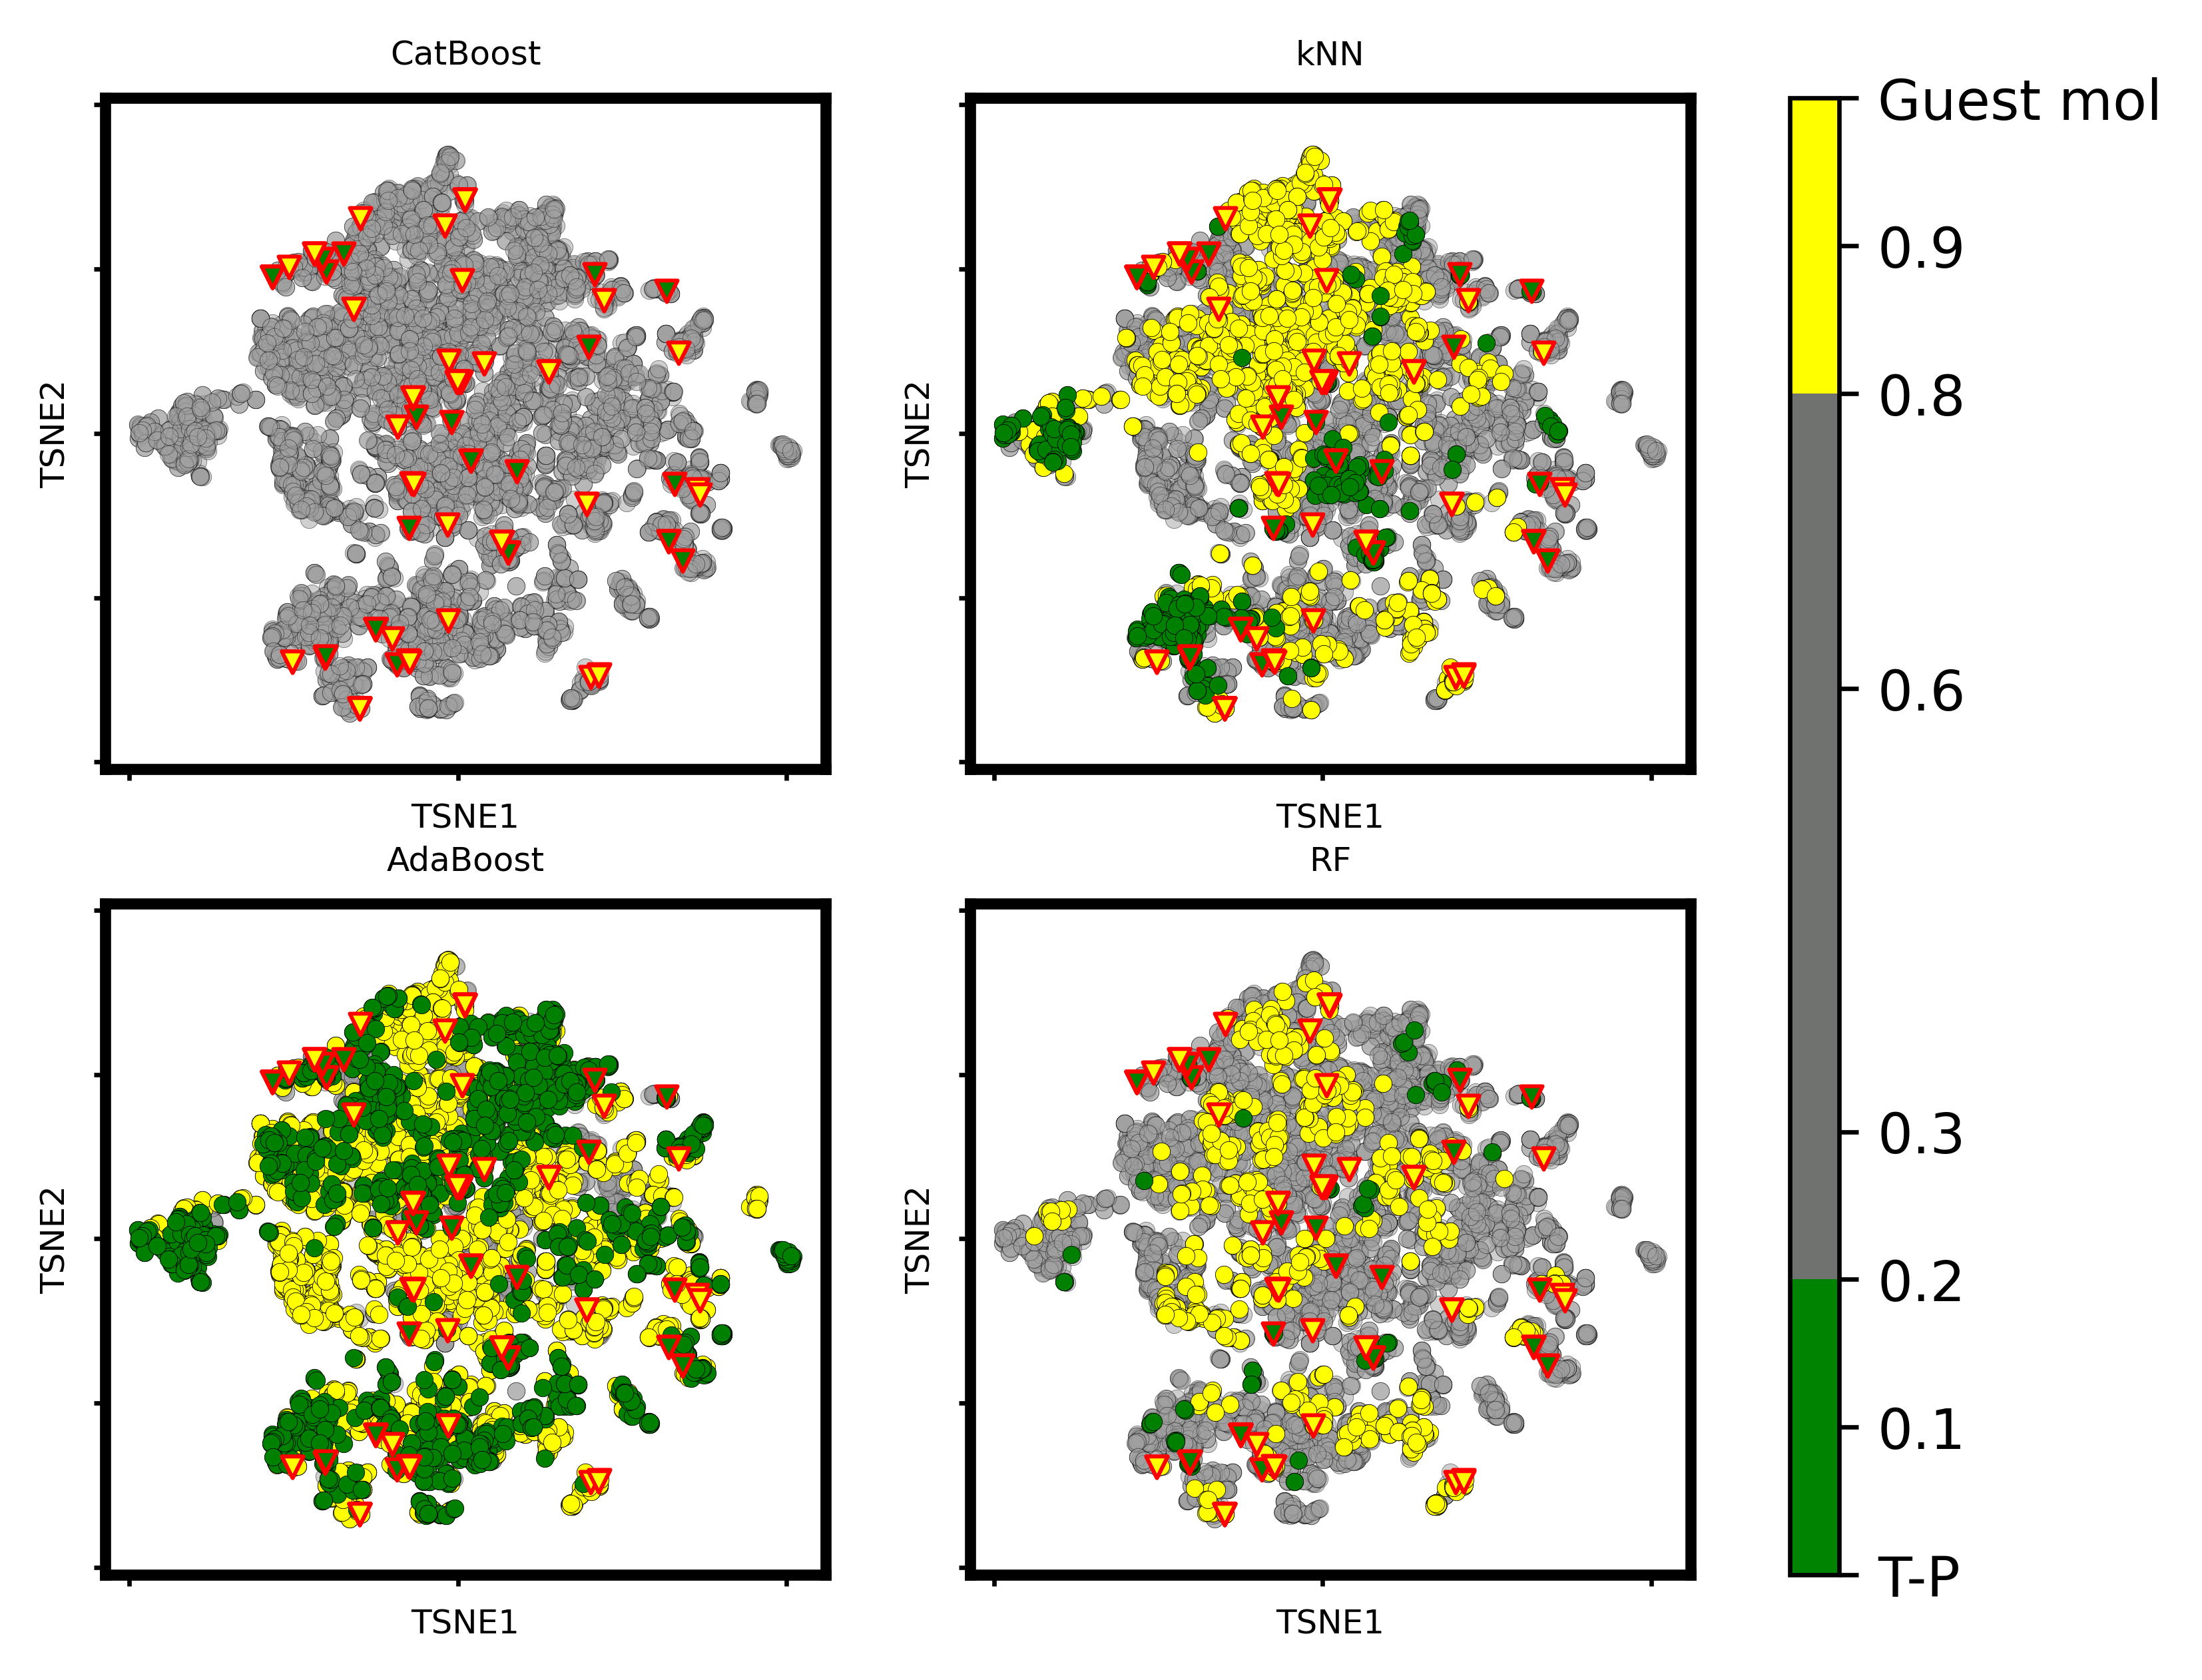

In [42]:
fig, axis = plt.subplots(2, 2, dpi=600)
plot_high_confident(axis[0][0], "CatBoost")
plot_high_confident(axis[0][1], "kNN")
# for i, ind in enumerate(chosen):
#     axis[0][1].text(xt_q[ind, 0], xt_q[ind, 1], str(i), fontsize=10)

# axis[0][1].scatter(xt_q[chosen, 0], xt_q[chosen, 1], s=30, marker="s", alpha=1, linewidths=1, c='blue')
plot_high_confident(axis[1][0], "AdaBoost")
plot_high_confident(axis[1][1], "RF")
bar = fig.colorbar(map, ax=axis, ticks=[0, 0.1, 0.2, 0.3, 0.6, 0.8,  0.9, 1], aspect=30)
bar.set_ticklabels(["T-P", 0.1, 0.2, 0.3, 0.6, 0.8,  0.9, "Guest mol"], size=10)
# plt.savefig("tsne.png")

# fig.colorbar()

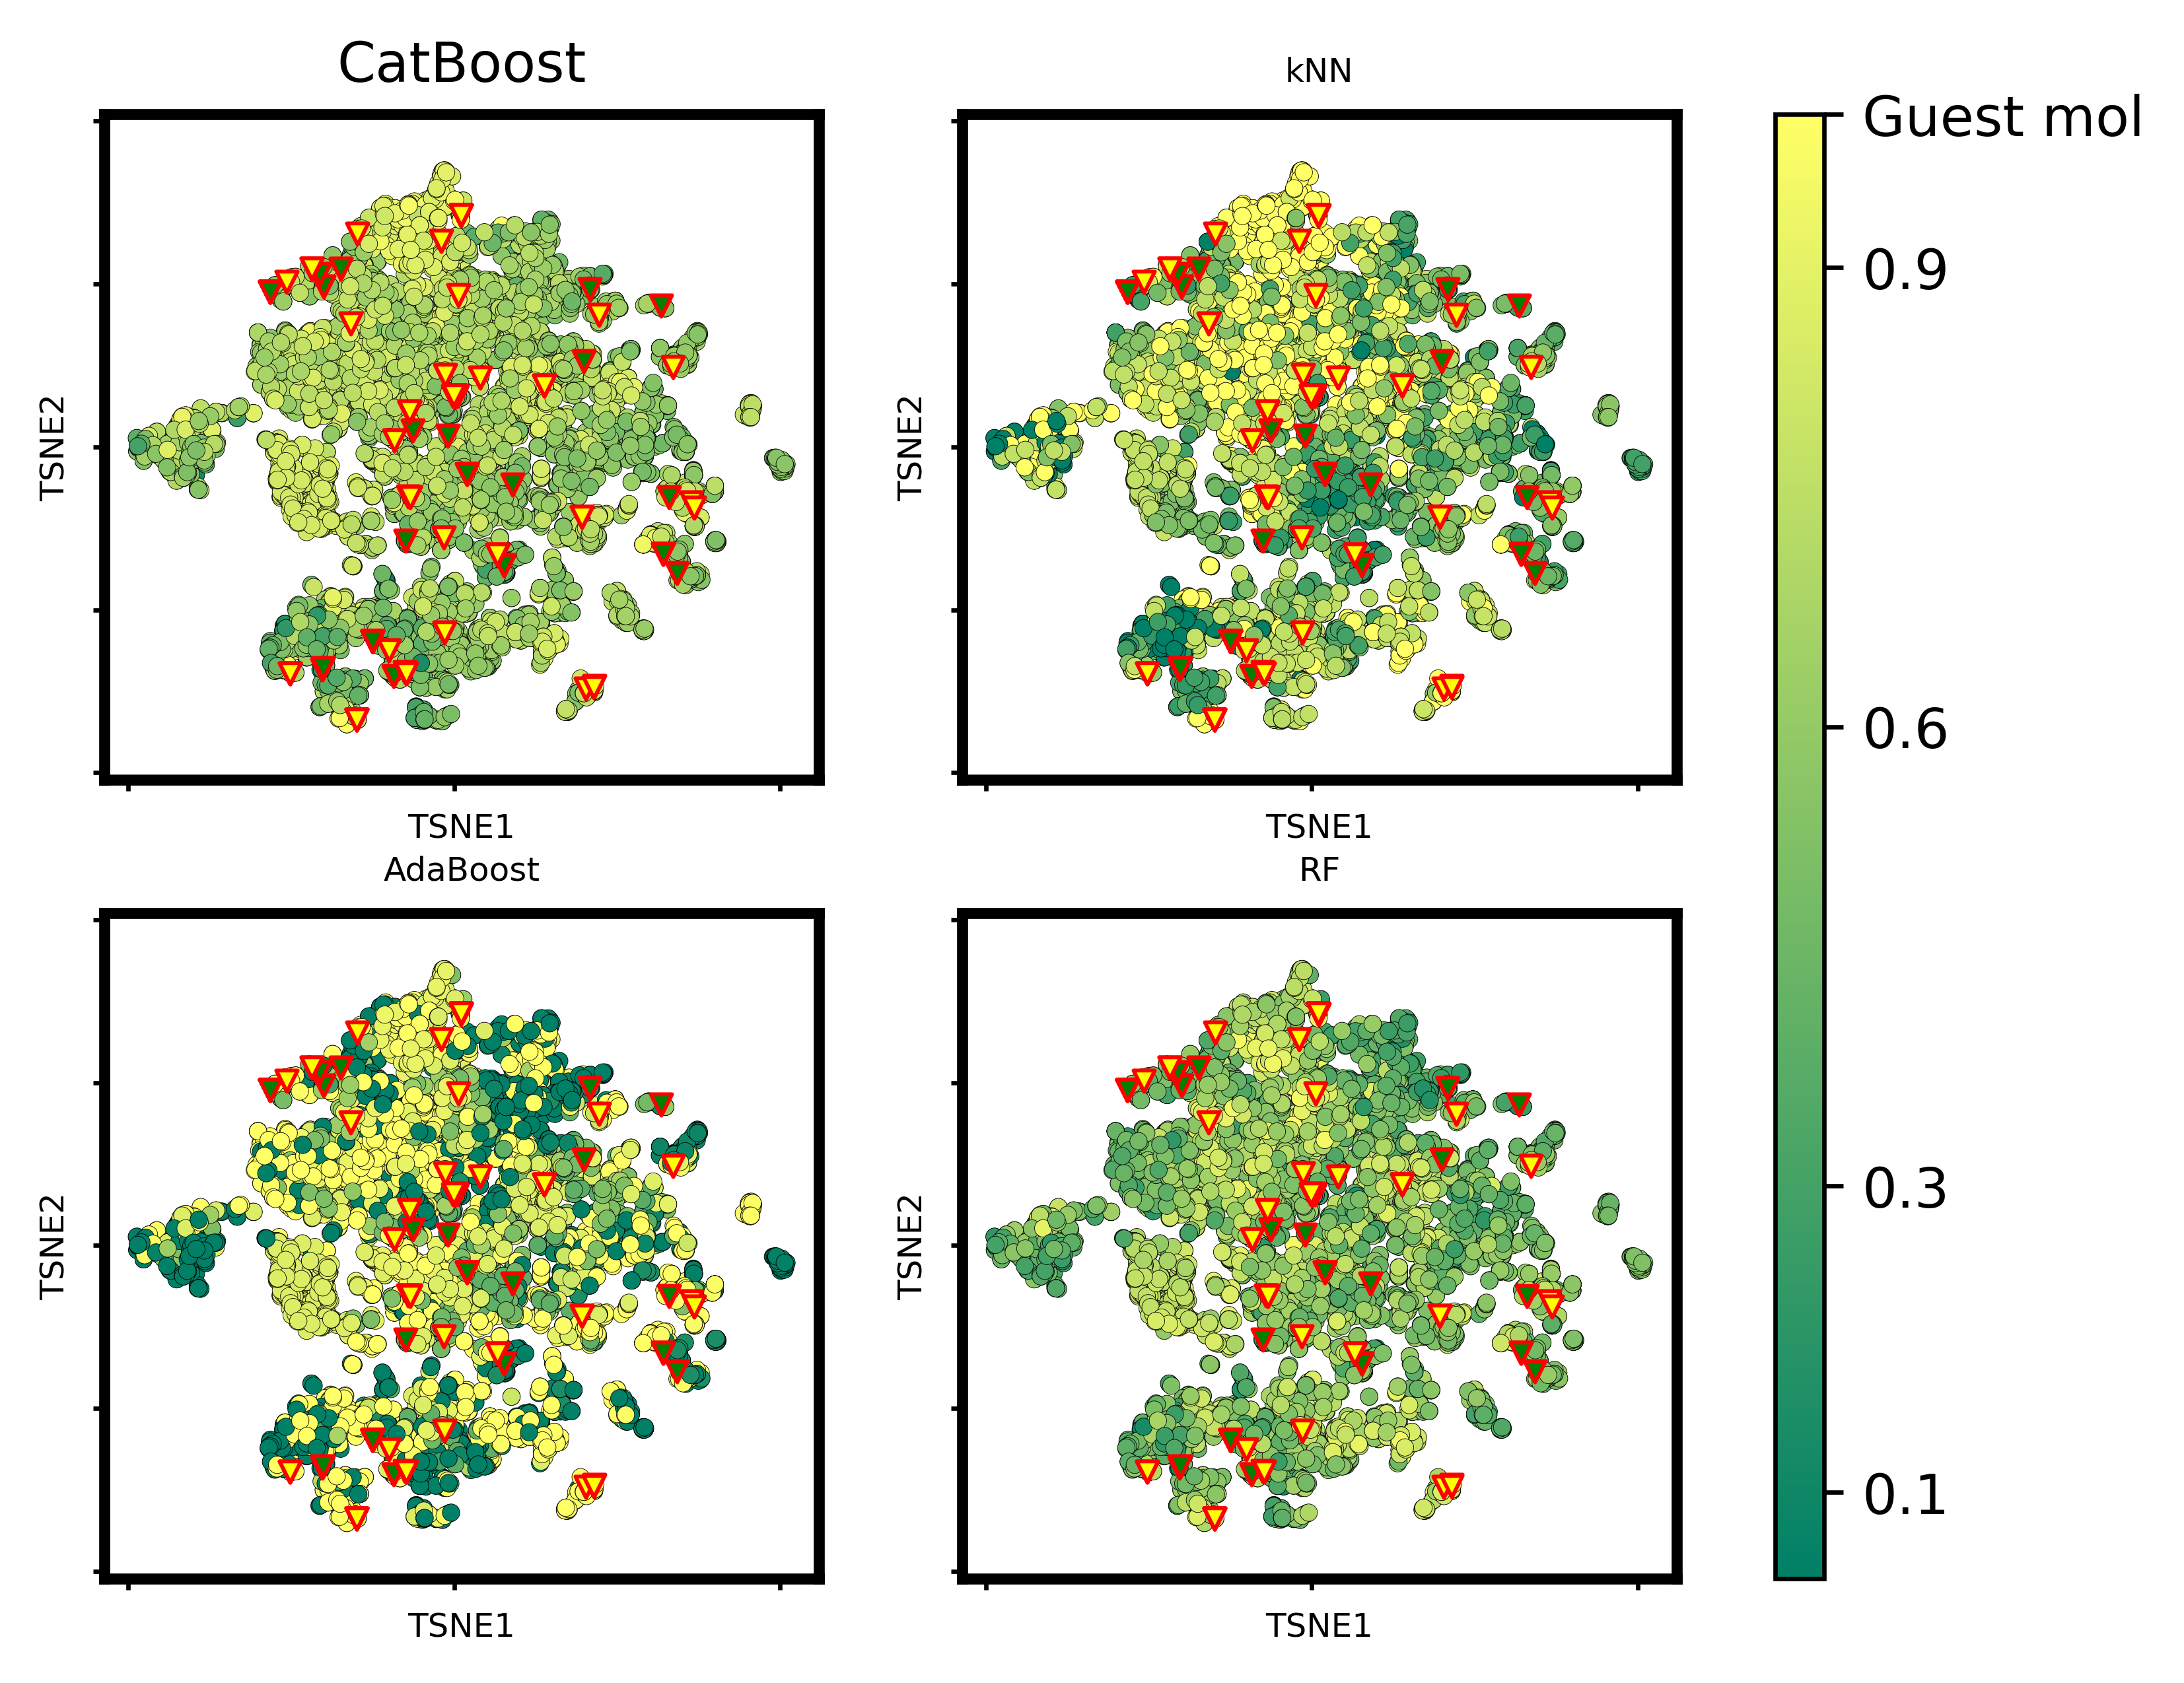

In [43]:
fig, axis = plt.subplots(2, 2, dpi=600)

axis[0][0].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["CatBoost"], cmap="summer")
axis[0][0].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[0][0].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label='guest molecules (main)')
axis[0][0].set_title("CatBoost", size=10)
axis[0][0].axis("equal")

axis[0][0].tick_params(axis='both',label1On=False, size=2)
axis[0][0].set_xlabel("TSNE1", size=6)
axis[0][0].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[0][0].spines[a].set_linewidth(2)


axis[0][1].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["kNN"], cmap="summer")
axis[0][1].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[0][1].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label='guest molecules (main)')
axis[0][1].set_title("kNN", size=6)
axis[0][1].axis("equal")

axis[0][1].tick_params(axis='both',label1On=False, size=2)
axis[0][1].set_xlabel("TSNE1", size=6)
axis[0][1].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[0][1].spines[a].set_linewidth(2)

axis[1][0].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["AdaBoost"], cmap="summer")
axis[1][0].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[1][0].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label=' guest molecules (main)')
axis[1][0].set_title("AdaBoost", size=6)
axis[1][0].axis("equal")

axis[1][0].tick_params(axis='both',label1On=False, size=2)
axis[1][0].set_xlabel("TSNE1", size=6)
axis[1][0].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[1][0].spines[a].set_linewidth(2)

map = axis[1][1].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["RF"], cmap="summer")
axis[1][1].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[1][1].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label='guest molecules  (main)')
axis[1][1].set_title("RF", size=6)
axis[1][1].axis("equal")

axis[1][1].tick_params(axis='both',label1On=False, size=2)
axis[1][1].set_xlabel("TSNE1", size=6)
axis[1][1].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[1][1].spines[a].set_linewidth(2)

# axis[0][0].legend()
bar = fig.colorbar(map, ax=axis, ticks=[0, 0.1, 0.3, 0.6, 0.9, 1], aspect=30)
bar.set_ticklabels(["T-P", 0.1, 0.3, 0.6, 0.9, "Guest mol"])